In [17]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import seaborn as sns
from dateutil.relativedelta import relativedelta
import datetime
import statsmodels.api as sm
from scipy.optimize import brute
from itertools import product

import warnings



# format notebook output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.core.display import display, HTML, Javascript
display(HTML("<style>.container { width:90% !important; }</style>"))

# style pandas display
pd.set_option('display.max_columns', None)

# matplotlib magic
%matplotlib inline

In [2]:
air_reserve = pd.read_csv('../../data_files/air_reserve.csv')
air_store_info = pd.read_csv('../../data_files/air_store_info.csv', encoding='utf-8')
air_visit_data = pd.read_csv('../../data_files/air_visit_data.csv')
date_info = pd.read_csv('../../data_files/date_info.csv')
hpg_reserve = pd.read_csv('../../data_files/hpg_reserve.csv')
hpg_store_info = pd.read_csv('../../data_files/hpg_store_info.csv')
sample_submission = pd.read_csv('../../data_files/sample_submission.csv')
store_id_relation = pd.read_csv('../../data_files/store_id_relation.csv')

In [3]:
air_stores = list(air_store_info['air_store_id'])
test = air_visit_data[air_visit_data['air_store_id']==air_stores[0]]
test.index = pd.DatetimeIndex(test['visit_date'])
display(test.head())

,air_store_id,visit_date,visitors
visit_date,,,
2016-07-01,air_0f0cdeee6c9bf3d7,2016-07-01,18
2016-07-02,air_0f0cdeee6c9bf3d7,2016-07-02,37
2016-07-03,air_0f0cdeee6c9bf3d7,2016-07-03,20
2016-07-04,air_0f0cdeee6c9bf3d7,2016-07-04,16
2016-07-05,air_0f0cdeee6c9bf3d7,2016-07-05,15


In [4]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error

In [5]:
from math import sqrt

In [6]:
def rms(actual_series, prediction_series):
    return mean_squared_error(actual_series, prediction_series)

The RMSLE is calculated as


where:

nn is the total number of observations 
pipi is your prediction of visitors
aiai is the actual number of visitors 
log(x)log⁡(x) is the natural logarithm of x

In [7]:
def rmsle(actual_series, prediction_series):
    return sqrt(mean_squared_log_error(actual_series, prediction_series))

In [8]:
first = pd.DataFrame([1,np.NAN,3,4])
second = pd.DataFrame(['a','b',np.NAN,'d'])

pd.merge(left=first, right=second, left_index=True, right_index=True).dropna()

# XORdropNA => [1,4],[a,d]

,0_x,0_y
0,1.0,a
3,4.0,d


In [9]:
data_col = 'visitors'

def build_model(iter_param, series, params_list, static_param=None):
  if static_param==None:
    ords = iter_param
    sords = (1,0,0,0)
  else:
    ords = static_param
    sords = iter_param
  try:
    mod = sm.tsa.statespace.SARIMAX(
        series, trend='n', order=ords, seasonal_order=sords
      )
    res = mod.fit(disp=0)
    params_list.append(tuple((ords, sords, res.aic, rms(series,res.predict()), rmsle(series,res.predict()))))
    print(params_list[-1])
  except:
    pass

'''m = []
res = build_model((1,0,0), test[data_col], m)
print('AIC: %s' % res.aic)
begin = len(test)-1
end = (datetime.datetime(2017,5,30).date()-test.index[-1].date()).days+len(test)
#res.predict(start=begin, end=end, dynamic=True)'''

"m = []\nres = build_model((1,0,0), test[data_col], m)\nprint('AIC: %s' % res.aic)\nbegin = len(test)-1\nend = (datetime.datetime(2017,5,30).date()-test.index[-1].date()).days+len(test)\n#res.predict(start=begin, end=end, dynamic=True)"

In [10]:
def parameter_search2(series, num_models, grid_diameter=3):
  models = []
  param_vals = range(grid_diameter)
  grid = list(product(param_vals,param_vals,param_vals))
  for ord_param in grid:
    for sord_param in [(p[0],p[1],p[2],7) for p in grid]:
      build_model(sord_param, series, models, ord_param)
  return sorted(models, key=lambda x: x[2])[:num_models], models

## Build some models and optimize the parameters

In [57]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
rerun = False
if rerun:
    mods = parameter_search2(test['visitors'], 5, 4)

In [35]:
mods

([((3, 1, 1),
   (0, 1, 2, 7),
   2075.0165798640974,
   160.86600699142213,
   0.5834925932577663),
  ((3, 1, 1),
   (1, 1, 2, 7),
   2075.3788406395188,
   159.52128652190868,
   0.5795586735210209),
  ((3, 1, 1),
   (2, 1, 1, 7),
   2075.978850501835,
   159.80699552411866,
   0.5810161328227316),
  ((3, 1, 1),
   (1, 1, 1, 7),
   2076.2371367155215,
   161.58757636465398,
   0.585383017429033),
  ((3, 1, 1),
   (2, 1, 2, 7),
   2077.4814335286719,
   159.51306080467691,
   0.5794245987938618)],
 [((0, 0, 0),
   (0, 1, 1, 7),
   2110.7558857864665,
   194.87665402412671,
   0.7681946428159536),
  ((0, 0, 0),
   (0, 1, 2, 7),
   2088.5417086049065,
   179.22066831696822,
   0.74419176868529),
  ((0, 0, 0),
   (0, 1, 3, 7),
   2089.8817626425762,
   179.09422975013933,
   0.7450684643108101),
  ((0, 0, 0),
   (1, 0, 0, 7),
   2223.7224609403997,
   239.20072770336463,
   0.8581854778597816),
  ((0, 0, 0),
   (1, 0, 1, 7),
   2178.5860467302655,
   197.13271546816333,
   0.768902559223

### Output the best with respect to each metric:

In [36]:
print('aic\n', [(i[0],i[1],i[2]) for i in sorted(mods[1], key=lambda x: x[2])[:5]])
print('rms\n', [(i[0],i[1],i[3]) for i in sorted(mods[1], key=lambda x: x[3])[:5]])
print('rmsle\n', [(i[0],i[1],i[4]) for i in sorted(mods[1], key=lambda x: x[4])[:5]])

aic
 [((3, 1, 1), (0, 1, 2, 7), 2075.0165798640974), ((3, 1, 1), (1, 1, 2, 7), 2075.3788406395188), ((3, 1, 1), (2, 1, 1, 7), 2075.978850501835), ((3, 1, 1), (1, 1, 1, 7), 2076.2371367155215), ((3, 1, 1), (2, 1, 2, 7), 2077.4814335286719)]
rms
 [((3, 1, 1), (2, 0, 3, 7), 150.96023993399709), ((3, 1, 1), (3, 0, 3, 7), 152.98023356833002), ((3, 1, 1), (3, 0, 2, 7), 155.20860158981412), ((3, 1, 1), (3, 0, 1, 7), 155.76474857861069), ((3, 1, 1), (2, 0, 1, 7), 155.7652316257288)]
rmsle
 [((3, 1, 1), (2, 0, 3, 7), 0.5665709366568519), ((3, 1, 1), (3, 0, 3, 7), 0.5713898049704313), ((3, 1, 1), (3, 0, 2, 7), 0.5718815894987753), ((3, 1, 1), (0, 0, 3, 7), 0.5729589945102304), ((3, 1, 1), (1, 0, 3, 7), 0.5730435407631144)]


## Detailed Analysis of the best model of each of these metrics

We also show the plots of the forecasts

In [37]:
metric_choices = {'aic': 2, 'rms': 3, 'rmsle': 4}

BEST AIC:
ARIMA(3, 1, 1)x(0, 1, 2, 7) - AIC:1954.1364629007915
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0700      0.074      0.950      0.342      -0.074       0.214
ar.L2         -0.1038      0.065     -1.595      0.111      -0.231       0.024
ar.L3         -0.2605      0.068     -3.817      0.000      -0.394      -0.127
ma.L1         -0.8867      0.037    -24.183      0.000      -0.959      -0.815
ma.S.L7       -0.8133    634.208     -0.001      0.999   -1243.837    1242.211
ma.S.L14      -0.1867    118.403     -0.002      0.999    -232.252     231.879
sigma2       158.1566      1e+05      0.002      0.999   -1.96e+05    1.97e+05


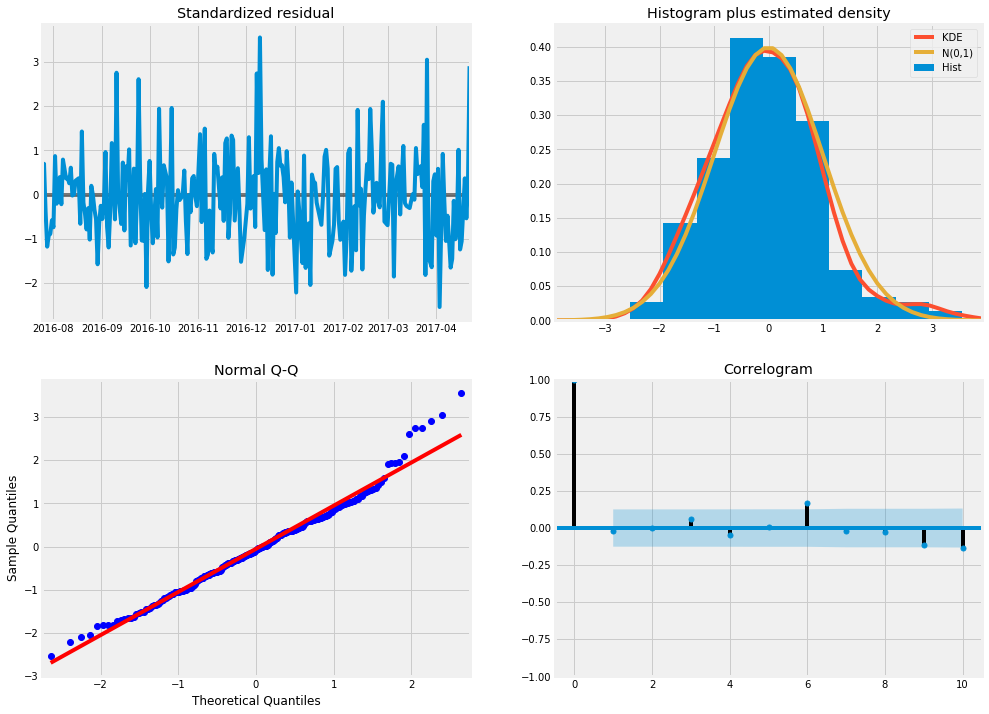

In [58]:
metric_choice=metric_choices['aic']
param, param_seasonal=sorted(mods[1], key=lambda x: x[metric_choice])[0][0:2]

best_aic_mod = sm.tsa.statespace.SARIMAX(test['visitors'],
                                order=param,
                                seasonal_order=param_seasonal,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

best_aic_results = best_aic_mod.fit()

print("BEST AIC:")
print("======================")

print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, best_aic_results.aic))

print(best_aic_results.summary().tables[1])

fig = best_aic_results.plot_diagnostics(figsize=(15, 12))
# plt.show()

Text(0.5,0,'Date')

Text(0,0.5,'CO2 Levels')

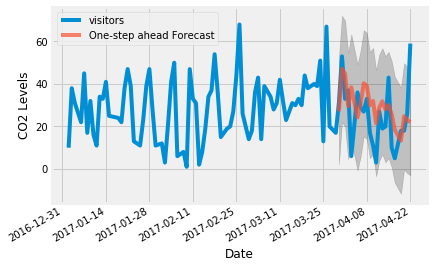

In [54]:
pred_best_aic = best_aic_results.get_prediction(start=pd.to_datetime('2017-03-30 00:00:00'), dynamic=False)
pred_ci_best_aic = pred_best_aic.conf_int()
ax = test['2017-01-01':].plot(label='observed')
pred_best_aic.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci_best_aic.index,
                pred_ci_best_aic.iloc[:, 0],
                pred_ci_best_aic.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Visitors')
plt.legend()

plt.show()

BEST RMS:
ARIMA(3, 1, 1)x(2, 0, 3, 7) - rms:156.39688232897265
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0681      0.073      0.939      0.348      -0.074       0.210
ar.L2         -0.0888      0.066     -1.354      0.176      -0.217       0.040
ar.L3         -0.2484      0.068     -3.644      0.000      -0.382      -0.115
ma.L1         -0.9054      0.032    -28.395      0.000      -0.968      -0.843
ar.S.L7        0.1262      0.878      0.144      0.886      -1.594       1.846
ar.S.L14       0.0825      0.567      0.145      0.884      -1.029       1.194
ma.S.L7        0.0831      0.881      0.094      0.925      -1.643       1.809
ma.S.L14      -0.1685      0.543     -0.311      0.756      -1.232       0.895
ma.S.L21      -0.0179      0.169     -0.106      0.916      -0.350       0.314
sigma2       161.1152     13.357     12.062      0.000     134.936  

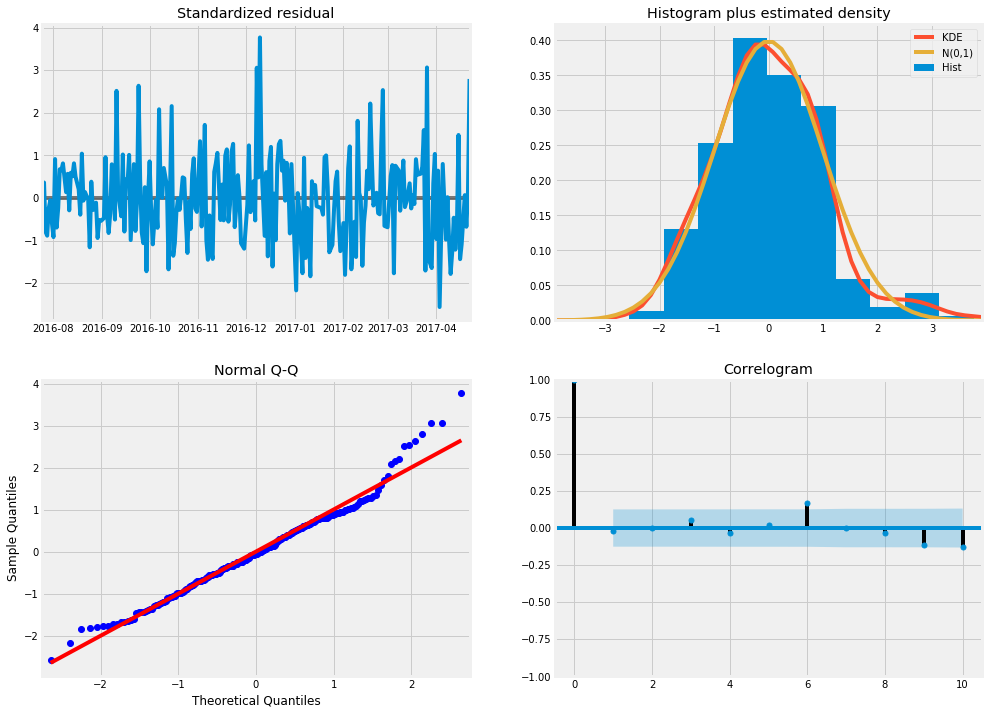

In [59]:
metric_choice=metric_choices['rms']
param, param_seasonal=sorted(mods[1], key=lambda x: x[metric_choice])[0][0:2]

best_rms_mod = sm.tsa.statespace.SARIMAX(test['visitors'],
                                order=param,
                                seasonal_order=param_seasonal,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

best_rms_results = best_rms_mod.fit()

print("BEST RMS:")
print("======================")


print('ARIMA{}x{} - rms:{}'.format(param, param_seasonal, rms(test['visitors'],best_rms_results.predict()) ))

print(best_rms_results.summary().tables[1])

fig = best_rms_results.plot_diagnostics(figsize=(15, 12))
# plt.show()

Text(0.5,0,'Date')

Text(0,0.5,'CO2 Levels')

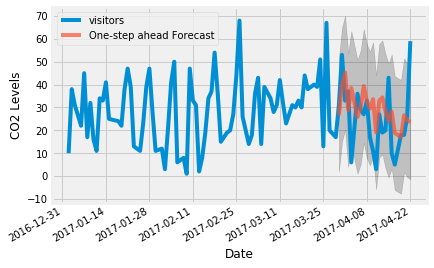

In [55]:
pred_best_rms = best_rms_results.get_prediction(start=pd.to_datetime('2017-03-30 00:00:00'), dynamic=False)
pred_ci_best_rms = pred_best_rms.conf_int()
ax = test['2017-01-01':].plot(label='observed')
pred_best_rms.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci_best_rms.index,
                pred_ci_best_rms.iloc[:, 0],
                pred_ci_best_rms.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Visitors')
plt.legend()

plt.show()

BEST RMSLE:
ARIMA(3, 1, 1)x(2, 0, 3, 7) - rmsle:0.5778472618929067
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0681      0.073      0.939      0.348      -0.074       0.210
ar.L2         -0.0888      0.066     -1.354      0.176      -0.217       0.040
ar.L3         -0.2484      0.068     -3.644      0.000      -0.382      -0.115
ma.L1         -0.9054      0.032    -28.395      0.000      -0.968      -0.843
ar.S.L7        0.1262      0.878      0.144      0.886      -1.594       1.846
ar.S.L14       0.0825      0.567      0.145      0.884      -1.029       1.194
ma.S.L7        0.0831      0.881      0.094      0.925      -1.643       1.809
ma.S.L14      -0.1685      0.543     -0.311      0.756      -1.232       0.895
ma.S.L21      -0.0179      0.169     -0.106      0.916      -0.350       0.314
sigma2       161.1152     13.357     12.062      0.000     134.9

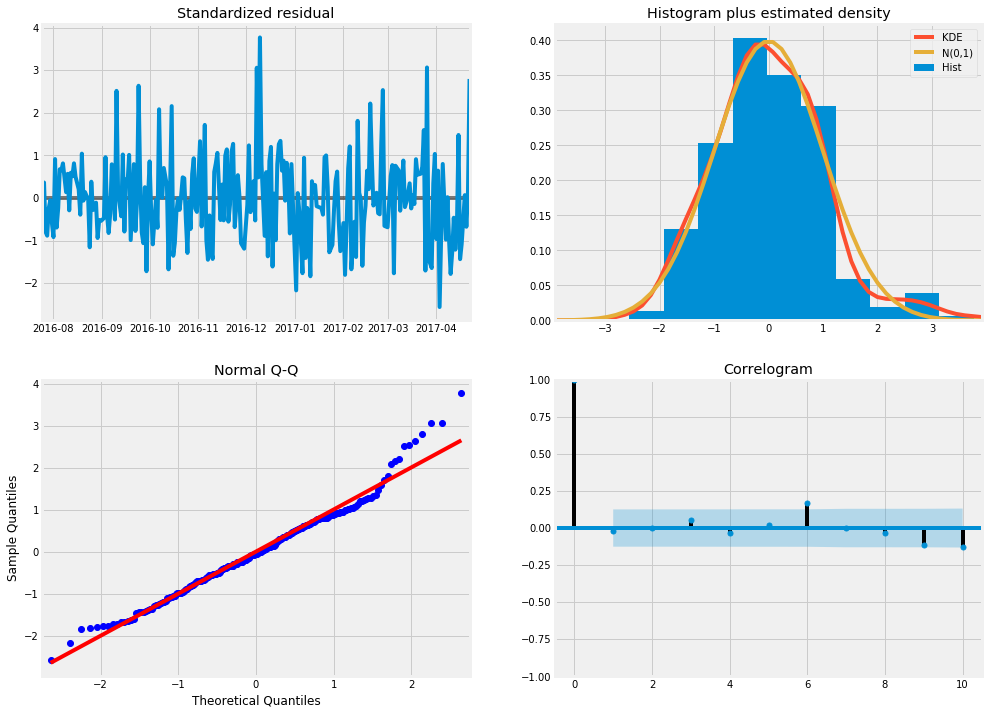

In [60]:
metric_choice=metric_choices['rmsle']
param, param_seasonal=sorted(mods[1], key=lambda x: x[metric_choice])[0][0:2]

best_rmsle_mod = sm.tsa.statespace.SARIMAX(test['visitors'],
                                order=param,
                                seasonal_order=param_seasonal,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

best_rmsle_results = best_rmsle_mod.fit()

print("BEST RMSLE:")
print("======================")


print('ARIMA{}x{} - rmsle:{}'.format(param, param_seasonal, rmsle(test['visitors'],best_rmsle_results.predict()) ))

print(best_rmsle_results.summary().tables[1])

fig = best_rmsle_results.plot_diagnostics(figsize=(15, 12))
# plt.show()

Text(0.5,0,'Date')

Text(0,0.5,'CO2 Levels')

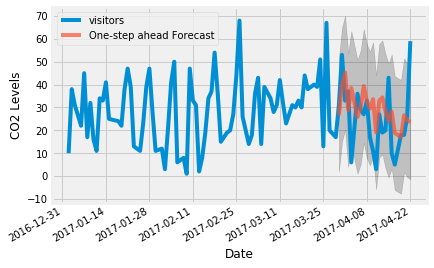

In [56]:
pred_best_rmsle = best_rmsle_results.get_prediction(start=pd.to_datetime('2017-03-30 00:00:00'), dynamic=False)
pred_ci_best_rmsle = pred_best_rmsle.conf_int()
ax = test['2017-01-01':].plot(label='observed')
pred_best_rmsle.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci_best_rmsle.index,
                pred_ci_best_rmsle.iloc[:, 0],
                pred_ci_best_rmsle.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Visitors')
plt.legend()

plt.show()

## Model construction that builds 40-day windows

In [271]:
import datetime as dt
from IPython.display import display

In [306]:
def build_40day_model(iter_param, series, params_list, static_param=None, forecast_length=40, quiet=False):
  if static_param==None:
    ords = iter_param
    sords = (1,0,0,0)
  else:
    ords = static_param
    sords = iter_param
  try:
      last = len(series)
      mod = sm.tsa.statespace.SARIMAX(
          series, trend='n', order=ords, seasonal_order=sords
        )
      res = mod.fit(disp=0)
      predictions_frame = res.predict(start = last-forecast_length, end= last-1, dynamic= False)
      if not quiet:
          print('ARIMA{}x{} - predictions:{} - AIC:{:03.5f} - RMS:{:03.5f} - RMSLE:{:03.5f}'.format(
                ords, 
                sords, 
                forecast_length,
                res.aic, 
                rms(series[-forecast_length:], predictions_frame), 
                rmsle(series[-forecast_length:],predictions_frame)
            )
          )  
      return (res.get_prediction(start = last-forecast_length, end= last-1, dynamic= False), res.aic, 
            rms(series[-forecast_length:], predictions_frame), 
            rmsle(series[-forecast_length:],predictions_frame))
  except:
    pass

In [307]:
test_models = []
test_ord_param, test_sord_param = (1,1,1), (1,1,1,7)
def build_historical_prediction_dataframe(ord_param, sord_param, model_list, dataframe, actuals_column, prediction_length=40, number_of_days_back=100):
    df_copy = dataframe.copy()
    for i in range(1, number_of_days_back-prediction_length):
        predictions_40, aic_40, rms_40, rmsle_40 = build_40day_model(sord_param, dataframe[actuals_column][:-i], model_list, ord_param, prediction_length, quiet=True)
        test_models.append(predictions_40.predicted_mean)
        df_copy.loc[predictions_40.predicted_mean.index[0], 'aic']=float("{0:.4f}".format(aic_40))
        df_copy.loc[predictions_40.predicted_mean.index[0], 'rms']=float("{0:.4f}".format(rms_40))
        df_copy.loc[predictions_40.predicted_mean.index[0], 'rmsle']=float("{0:.5f}".format(rmsle_40))
        for (idx, val) in [(idx,val) for idx, val in predictions_40.predicted_mean.iteritems()]:
            df_copy.loc[idx, (str(1+predictions_40.predicted_mean.index.get_loc(idx))+"_days_out_prediction")]=float("{0:.2f}".format(val))
    for j in range(40):
        predictions_40, aic_40, rms_40, rmsle_40 = build_40day_model(sord_param, dataframe[actuals_column], model_list, ord_param, prediction_length-j, quiet=True)
        df_copy.loc[predictions_40.predicted_mean.index[0], 'aic']=float("{0:.4f}".format(aic_40))
        df_copy.loc[predictions_40.predicted_mean.index[0], 'rms']=float("{0:.4f}".format(rms_40))
        df_copy.loc[predictions_40.predicted_mean.index[0], 'rmsle']=float("{0:.5f}".format(rmsle_40))
        test_models.append(predictions_40.predicted_mean)
        for (idx, val) in [(idx,val) for idx, val in predictions_40.predicted_mean.iteritems()]:
            df_copy.loc[idx, (str(1+predictions_40.predicted_mean.index.get_loc(idx))+"_days_out_prediction")]=float("{0:.4f}".format(val))
    return df_copy
historical_prediction_output = build_historical_prediction_dataframe(test_ord_param, test_sord_param, test_models, test, 'visitors', 40, 100)
print("******Finished Predictions*******")

In [308]:
with pd.option_context('display.max_rows', 100, 'display.max_columns', 100):
    historical_prediction_output[-100:]

,air_store_id,visit_date,visitors,aic,rms,rmsle,1_days_out_prediction,2_days_out_prediction,3_days_out_prediction,4_days_out_prediction,5_days_out_prediction,6_days_out_prediction,7_days_out_prediction,8_days_out_prediction,9_days_out_prediction,10_days_out_prediction,11_days_out_prediction,12_days_out_prediction,13_days_out_prediction,14_days_out_prediction,15_days_out_prediction,16_days_out_prediction,17_days_out_prediction,18_days_out_prediction,19_days_out_prediction,20_days_out_prediction,21_days_out_prediction,22_days_out_prediction,23_days_out_prediction,24_days_out_prediction,25_days_out_prediction,26_days_out_prediction,27_days_out_prediction,28_days_out_prediction,29_days_out_prediction,30_days_out_prediction,31_days_out_prediction,32_days_out_prediction,33_days_out_prediction,34_days_out_prediction,35_days_out_prediction,36_days_out_prediction,37_days_out_prediction,38_days_out_prediction,39_days_out_prediction,40_days_out_prediction
visit_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-12-28,air_0f0cdeee6c9bf3d7,2016-12-28,45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-29,air_0f0cdeee6c9bf3d7,2016-12-29,33,1609.0553,216.0816,0.83134,41.0400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-30,air_0f0cdeee6c9bf3d7,2016-12-30,47,1615.9593,214.4935,0.83079,44.1500,44.1600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-02,air_0f0cdeee6c9bf3d7,2017-01-02,10,1624.2111,219.4548,0.83587,35.9700,36.1000,36.1100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-03,air_0f0cdeee6c9bf3d7,2017-01-03,38,1631.1101,202.6217,0.81372,28.5700,28.5700,28.6100,28.6100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,air_0f0cdeee6c9bf3d7,2017-01-04,31,1640.1485,208.7151,0.81512,30.6300,30.6200,30.6200,30.6100,30.6100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-06,air_0f0cdeee6c9bf3d7,2017-01-06,22,1647.0915,208.8352,0.81502,33.4100,33.4100,33.4600,33.4700,33.6400,33.6500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-07,air_0f0cdeee6c9bf3d7,2017-01-07,45,1654.4400,207.4796,0.81497,33.6600,33.5200,33.5400,33.6100,33.6200,33.7800,33.7800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-08,air_0f0cdeee6c9bf3d7,2017-01-08,17,1661.3444,204.3045,0.81370,35.6800,35.6800,35.7400,35.7200,35.6900,35.6900,35.6400,35.6400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


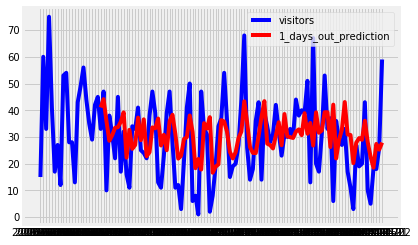

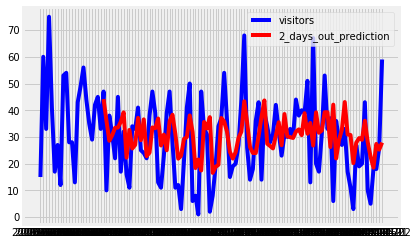

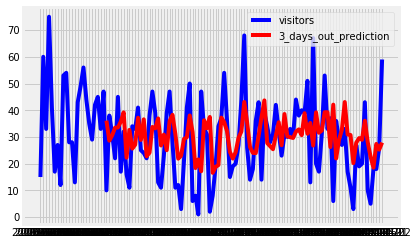

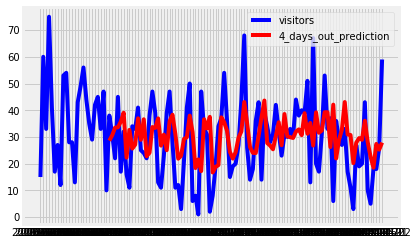

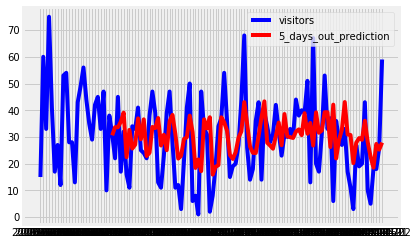

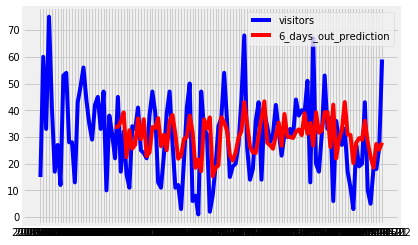

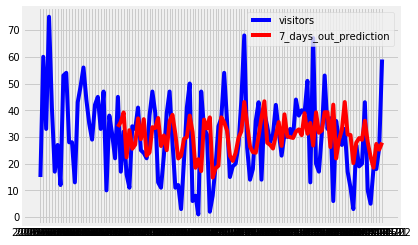

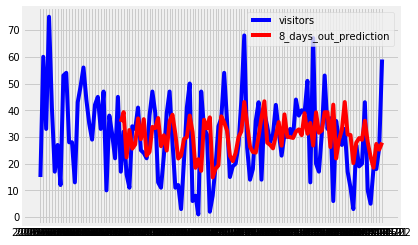

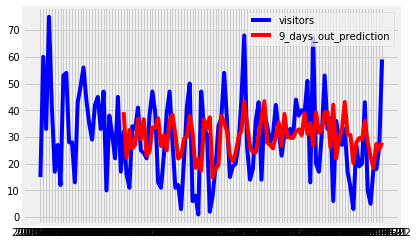

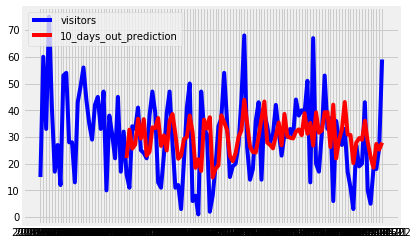

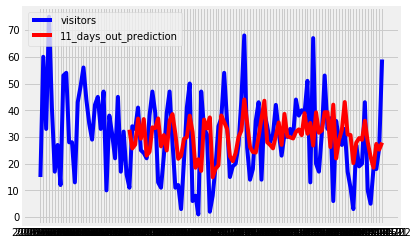

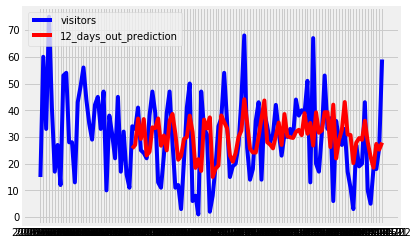

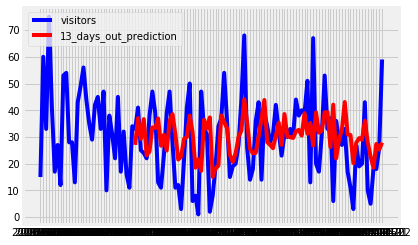

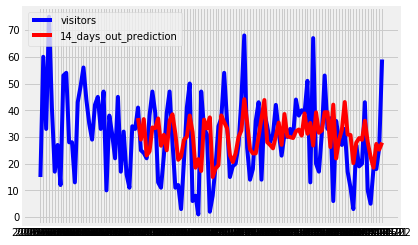

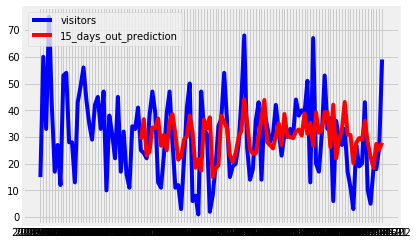

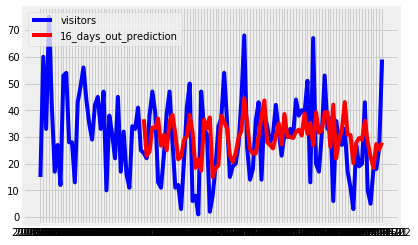

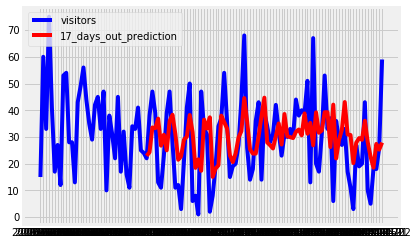

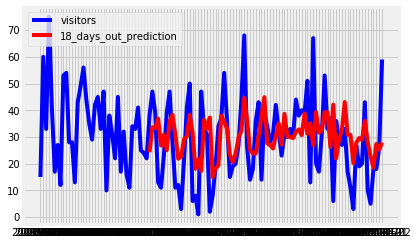

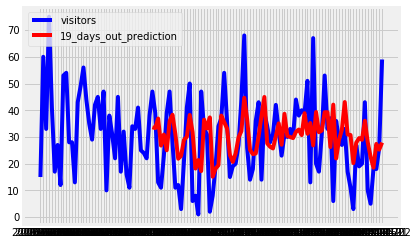

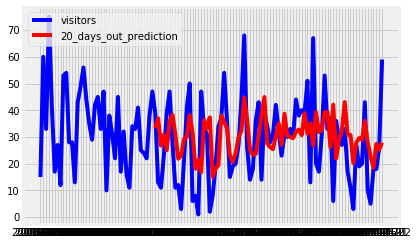

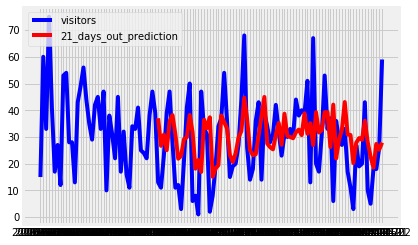

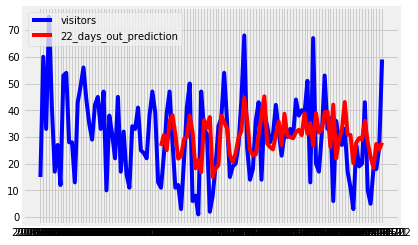

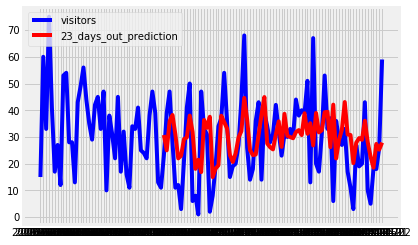

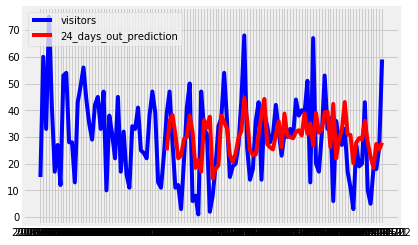

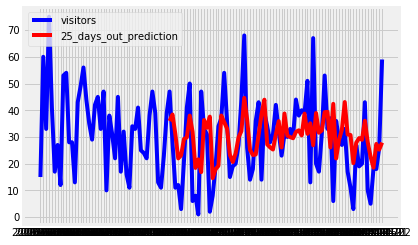

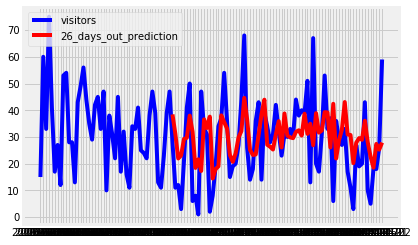

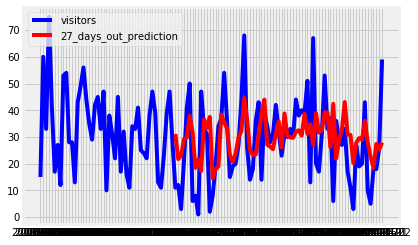

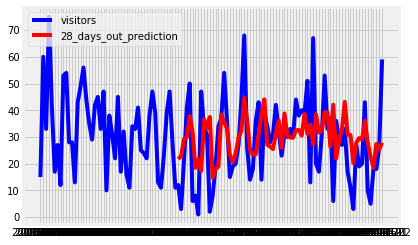

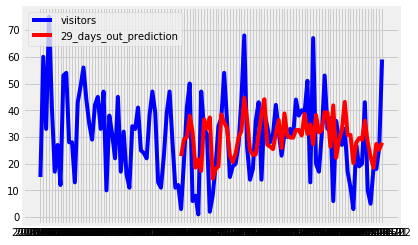

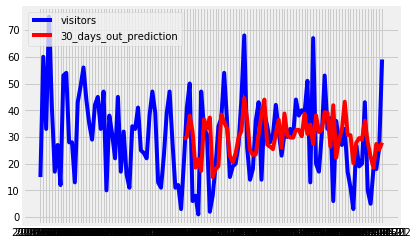

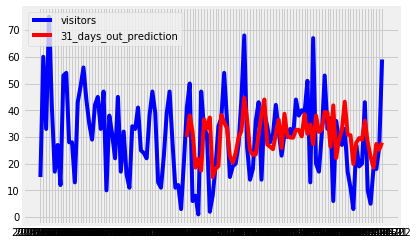

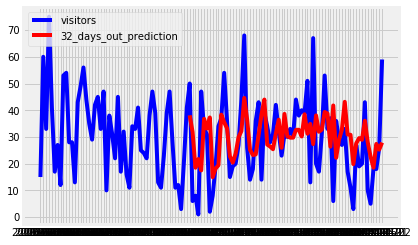

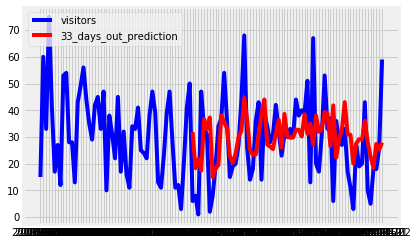

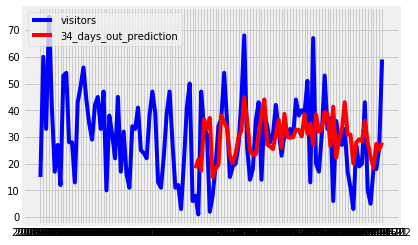

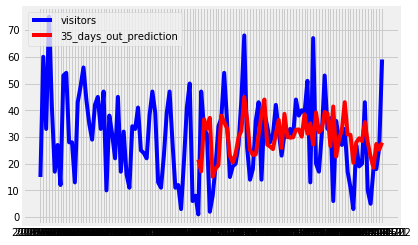

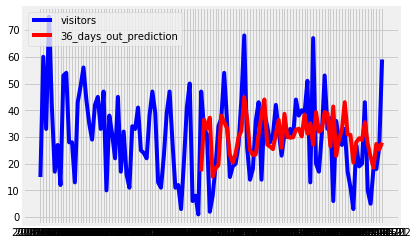

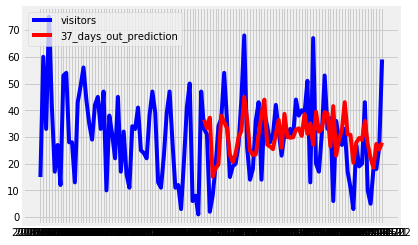

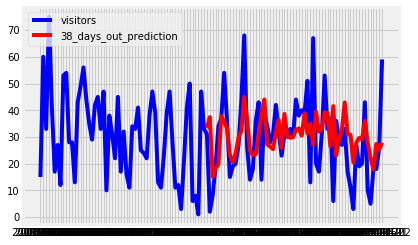

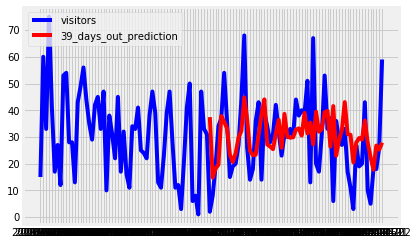

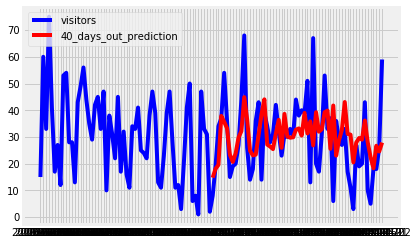

In [317]:
historical_prediction_output.plot(label='Nondynamic Forecast', ax=ax)
# pred_dynamic_ci = predictions_40.conf_int()


# test_copy = test.copy()
# test_copy['preds'] = predictions_40.predicted_mean
# test_copy[['lower_pred', 'upper_pred']]=pred_dynamic_ci
# test_copy['error'] = test_copy['visitors']-test_copy['preds']
# test_copy['outside_CI'] = np.where((test_copy['visitors']>test_copy['upper_pred']) | (test_copy['visitors']<test_copy['lower_pred']), True, False)

for i in range(40):
    col_name = str((i+1))+"_days_out_prediction"
    _ = plt.tight_layout()
    _ = plt.plot(figsize=(20,4))
    _ = plt.plot(historical_prediction_output['visit_date'][-120:], historical_prediction_output['visitors'][-120:], 'b-', label='visitors')
    _ = plt.plot(historical_prediction_output['visit_date'][-120:], historical_prediction_output[col_name][-120:], 'r-', label=col_name)
    _ = plt.legend(loc='best')
    plt.show()

# test_copy
# ax.fill_between(pred_dynamic_ci.index,
#                 pred_dynamic_ci.iloc[:, 0],
#                 pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

# ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1998-01-01'), test['visitors'].index[-1],
#                  alpha=.1, zorder=-1)

# ax.set_xlabel('Date')
# ax.set_ylabel('CO2 Levels')

# plt.legend()
# plt.show()